# DAT300 - Compulsory Assignment 2 (CA2)
## Group
CA2-8

## Orion
Username: dat300-22-8
Script Name: low_epochs.py
Job ID: 11581165

## Kaggle Group Name:
1000 B.C.

## Members:
- Aditya Dey
- Muhammad Ashar
- Raul Andreas Sanjines Morato

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dat300-h2022-ca2/test.h5
/kaggle/input/dat300-h2022-ca2/sample_submission.csv
/kaggle/input/dat300-h2022-ca2/train.h5


In [3]:
import matplotlib.pyplot as plt
import h5py
import warnings

warnings.filterwarnings("ignore")

## 1. Reading Dataset

In [4]:
train_raw = h5py.File('/kaggle/input/dat300-h2022-ca2/train.h5', 'r')
test_raw = h5py.File('/kaggle/input/dat300-h2022-ca2/test.h5', 'r')

In [5]:
list(train_raw.keys())

['X', 'y']

In [6]:
X_train_raw = np.asarray(train_raw['X'])
y_train_raw = np.asarray(train_raw['y'])

X_test_raw = np.asarray(test_raw['X'])

In [7]:
print(f'X Train shape: {X_train_raw.shape},\ny Train shape: {y_train_raw.shape},\nX Test shape : {X_test_raw.shape}')

X Train shape: (2780, 128, 128, 3),
y Train shape: (2780, 128, 128, 1),
X Test shape : (695, 128, 128, 3)


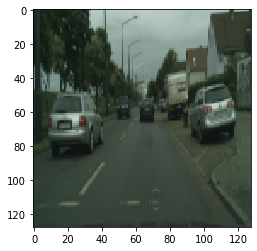

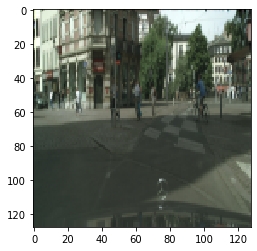

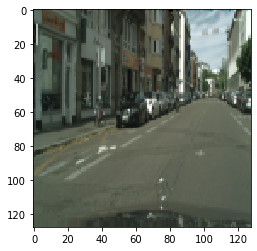

In [8]:
plt.imshow(X_train_raw[1], interpolation='nearest')
plt.show()
plt.imshow(X_train_raw[50], interpolation='nearest')
plt.show()
plt.imshow(X_train_raw[1200], interpolation='nearest')
plt.show()

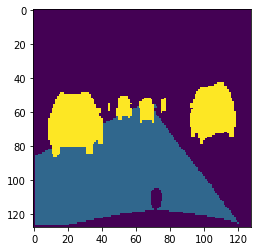

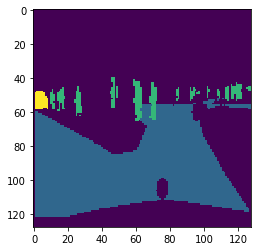

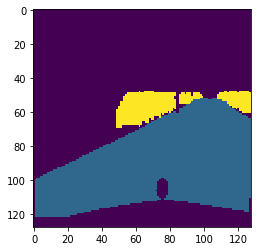

In [9]:
plt.imshow(y_train_raw[1], interpolation='nearest')
plt.show()
plt.imshow(y_train_raw[50], interpolation='nearest')
plt.show()
plt.imshow(y_train_raw[1200], interpolation='nearest')
plt.show()

## 2. Preprocessing

In [10]:
y_train_raw = np.asarray(y_train_raw != 0, dtype="int")
# y_train_raw

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_valid,y_train, y_valid = train_test_split(X_train_raw, y_train_raw, test_size=0.3, random_state=1)

In [12]:
print(f'X_train shape: {X_train.shape}\nX_valid shape: {X_valid.shape}')
print(f'y_train shape: {y_train.shape}\ny_valid shape: {y_valid.shape}')

X_train shape: (1946, 128, 128, 3)
X_valid shape: (834, 128, 128, 3)
y_train shape: (1946, 128, 128, 1)
y_valid shape: (834, 128, 128, 1)


In [13]:
# Standardize data based on training data

mean_vals = np.mean(X_train, axis=0)
std_val = np.std(X_train)
X_train_centered = (X_train - mean_vals)/std_val



print(f'X_train_center shape: {X_train_centered.shape}')
# \nX_valid_centered shape: {X_test_centered.shape}\nX_test_centered shape: {X_test_centered.shape}')

X_train_center shape: (1946, 128, 128, 3)


In [14]:
X_valid_centered = (X_valid - mean_vals)/std_val
print(f'X_valid_center shape: {X_valid_centered.shape}')

X_valid_center shape: (834, 128, 128, 3)


In [15]:
X_test_centered = (X_test_raw - mean_vals)/std_val
print(f'X_test_center shape: {X_test_centered.shape}')

X_test_center shape: (695, 128, 128, 3)


## 3. Basic Unet Model

In [16]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x


def get_unet(input_img, n_filters=16, dropout=0.0, batchnorm=True, n_classes=2):
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(n_classes, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [17]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
input_img = Input(shape=(128,128,3))
model = get_unet(input_img, n_filters = 32, dropout = 0.1, batchnorm = True, n_classes = 1)
model.summary()

2022-11-10 17:11:25.264579: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-10 17:11:25.387422: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-10 17:11:25.388344: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-10 17:11:25.389615: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [20]:
from tensorflow.keras.optimizers import Adam


model.compile(Adam(0.0002), loss="binary_crossentropy", metrics=["accuracy"])

In [19]:
from tensorflow.keras.callbacks import ModelCheckpoint

model_checkpoint_callback = ModelCheckpoint(
    filepath='/abc/checkpoint',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

#Without Standardization
history = model.fit(X_train,y_train, batch_size=16, epochs=10, validation_data=(X_valid, y_valid), callbacks=[model_checkpoint_callback])

# With Standardization
# history = model.fit(X_train_centered,y_train, batch_size=16, epochs=5, validation_data=(X_valid_centered, y_valid))

2022-11-10 15:12:40.385501: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 382599168 exceeds 10% of free system memory.
2022-11-10 15:12:40.955199: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-11-10 15:12:40.965318: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000140000 Hz


Epoch 1/10


2022-11-10 15:12:43.175422: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8
2022-11-10 15:12:48.482541: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-11-10 15:12:49.248977: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11


122/122 [==============================] - 19s 81ms/step - loss: 0.3585 - accuracy: 0.8304 - val_loss: 0.4961 - val_accuracy: 0.7777
Epoch 2/10
122/122 [==============================] - 8s 67ms/step - loss: 0.1648 - accuracy: 0.9336 - val_loss: 0.3120 - val_accuracy: 0.8821
Epoch 3/10
122/122 [==============================] - 8s 67ms/step - loss: 0.1387 - accuracy: 0.9460 - val_loss: 0.2171 - val_accuracy: 0.9245
Epoch 4/10
122/122 [==============================] - 8s 67ms/step - loss: 0.1189 - accuracy: 0.9538 - val_loss: 0.1362 - val_accuracy: 0.9482
Epoch 5/10
122/122 [==============================] - 8s 67ms/step - loss: 0.1068 - accuracy: 0.9593 - val_loss: 0.1167 - val_accuracy: 0.9564
Epoch 6/10
122/122 [==============================] - 8s 68ms/step - loss: 0.0965 - accuracy: 0.9631 - val_loss: 0.1066 - val_accuracy: 0.9598
Epoch 7/10
122/122 [==============================] - 8s 68ms/step - loss: 0.0932 - accuracy: 0.9636 - val_loss: 0.1048 - val_accuracy: 0.9608
Epoch 8/1

Best Accuracy Score: 0.9701

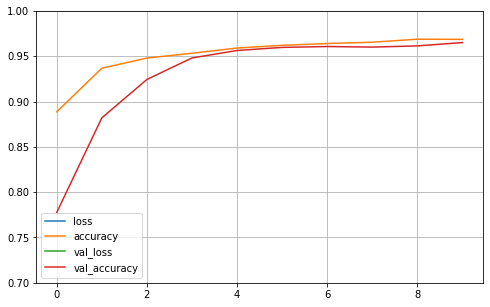

In [20]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0.70,1)
plt.show()

### 3.1 Hyperparameter Tuning

From now on, some libraries are re-imported to avoid re-running the previous blocks when working on a different pc

#### Dimesion of Filters -> 16, Dropout -> 0.1 Learning Rate -> 0.0001 and Batch Size --> 16

In [22]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model

input_img = Input(shape=(128,128,3))
model = get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True, n_classes = 1)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_57 (Conv2D)              (None, 128, 128, 16) 448         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_54 (BatchNo (None, 128, 128, 16) 64          conv2d_57[0][0]                  
__________________________________________________________________________________________________
activation_54 (Activation)      (None, 128, 128, 16) 0           batch_normalization_54[0][0]     
____________________________________________________________________________________________

In [23]:
from tensorflow.keras.optimizers import Adam

model.compile(Adam(0.0001), loss="binary_crossentropy", metrics=["accuracy"])

In [24]:
from tensorflow.keras.callbacks import ModelCheckpoint

model_checkpoint_callback = ModelCheckpoint(
    filepath='/abc/checkpoint',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

history_params = model.fit(X_train,y_train, batch_size=16, epochs=10, validation_data=(X_valid, y_valid), callbacks=[model_checkpoint_callback])

2022-11-10 17:14:55.676479: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 382599168 exceeds 10% of free system memory.
2022-11-10 17:14:56.471200: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 382599168 exceeds 10% of free system memory.
2022-11-10 17:14:57.046717: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-11-10 17:15:00.617960: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


122/122 [==============================] - 16s 53ms/step - loss: 0.4663 - accuracy: 0.7851 - val_loss: 1.0533 - val_accuracy: 0.5304
Epoch 2/10
122/122 [==============================] - 5s 40ms/step - loss: 0.2581 - accuracy: 0.9180 - val_loss: 0.3334 - val_accuracy: 0.8667
Epoch 3/10
122/122 [==============================] - 5s 40ms/step - loss: 0.2183 - accuracy: 0.9292 - val_loss: 0.2817 - val_accuracy: 0.8829
Epoch 4/10
122/122 [==============================] - 5s 42ms/step - loss: 0.1981 - accuracy: 0.9347 - val_loss: 0.2116 - val_accuracy: 0.9234
Epoch 5/10
122/122 [==============================] - 5s 39ms/step - loss: 0.1825 - accuracy: 0.9398 - val_loss: 0.2058 - val_accuracy: 0.9258
Epoch 6/10
122/122 [==============================] - 5s 40ms/step - loss: 0.1702 - accuracy: 0.9440 - val_loss: 0.2030 - val_accuracy: 0.9251
Epoch 7/10
122/122 [==============================] - 5s 39ms/step - loss: 0.1608 - accuracy: 0.9464 - val_loss: 0.1698 - val_accuracy: 0.9420
Epoch 8/1

Best Accuracy Score: 0.9533

#### Dimesion of Filters -> 64, Dropout -> 0.2, Learning Rate -> 0.0002 and Batch Size --> 16

In [36]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model

input_img = Input(shape=(128,128,3))
model = get_unet(input_img, n_filters = 64, dropout = 0.2, batchnorm = True, n_classes = 1)
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_114 (Conv2D)             (None, 128, 128, 64) 1792        input_8[0][0]                    
__________________________________________________________________________________________________
batch_normalization_108 (BatchN (None, 128, 128, 64) 256         conv2d_114[0][0]                 
__________________________________________________________________________________________________
activation_108 (Activation)     (None, 128, 128, 64) 0           batch_normalization_108[0][0]    
____________________________________________________________________________________________

In [37]:
from tensorflow.keras.optimizers import Adam

model.compile(Adam(0.0002), loss="binary_crossentropy", metrics=["accuracy"])

In [38]:
from tensorflow.keras.callbacks import ModelCheckpoint

model_checkpoint_callback = ModelCheckpoint(
    filepath='/abc/checkpoint',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

history_params = model.fit(X_train,y_train, batch_size=16, epochs=20, validation_data=(X_valid, y_valid), callbacks=[model_checkpoint_callback])

Epoch 1/20
122/122 [==============================] - 24s 176ms/step - loss: 0.2475 - accuracy: 0.8997 - val_loss: 3.1340 - val_accuracy: 0.6814
Epoch 2/20
122/122 [==============================] - 20s 161ms/step - loss: 0.1574 - accuracy: 0.9383 - val_loss: 0.3796 - val_accuracy: 0.8525
Epoch 3/20
122/122 [==============================] - 20s 162ms/step - loss: 0.1306 - accuracy: 0.9499 - val_loss: 0.2505 - val_accuracy: 0.9149
Epoch 4/20
122/122 [==============================] - 20s 162ms/step - loss: 0.1126 - accuracy: 0.9570 - val_loss: 0.1231 - val_accuracy: 0.9572
Epoch 5/20
122/122 [==============================] - 20s 161ms/step - loss: 0.1035 - accuracy: 0.9606 - val_loss: 0.1078 - val_accuracy: 0.9598
Epoch 6/20
122/122 [==============================] - 20s 162ms/step - loss: 0.0972 - accuracy: 0.9629 - val_loss: 0.1160 - val_accuracy: 0.9600
Epoch 7/20
122/122 [==============================] - 20s 162ms/step - loss: 0.0929 - accuracy: 0.9640 - val_loss: 0.0988 - val_ac

Best Accuracy Score: 0.9815

#### Dimesion of Filters -> 64, Dropout -> 0.2, Learning Rate -> 0.0002 and Batch Size --> 32

In [30]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model

input_img = Input(shape=(128,128,3))
model = get_unet(input_img, n_filters = 64, dropout = 0.2, batchnorm = True, n_classes = 1)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, 128, 128, 64) 1792        input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_90 (BatchNo (None, 128, 128, 64) 256         conv2d_95[0][0]                  
__________________________________________________________________________________________________
activation_90 (Activation)      (None, 128, 128, 64) 0           batch_normalization_90[0][0]     
____________________________________________________________________________________________

In [31]:
from tensorflow.keras.optimizers import Adam

model.compile(Adam(0.0002), loss="binary_crossentropy", metrics=["accuracy"])

In [32]:
from tensorflow.keras.callbacks import ModelCheckpoint

model_checkpoint_callback = ModelCheckpoint(
    filepath='/abc/checkpoint',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

history_params = model.fit(X_train,y_train, batch_size=32, epochs=10, validation_data=(X_valid, y_valid), callbacks=[model_checkpoint_callback])

Epoch 1/10
61/61 [==============================] - 25s 342ms/step - loss: 0.3010 - accuracy: 0.8731 - val_loss: 0.5179 - val_accuracy: 0.7862
Epoch 2/10
61/61 [==============================] - 18s 292ms/step - loss: 0.1794 - accuracy: 0.9309 - val_loss: 0.7423 - val_accuracy: 0.7711
Epoch 3/10
61/61 [==============================] - 18s 290ms/step - loss: 0.1486 - accuracy: 0.9429 - val_loss: 0.7210 - val_accuracy: 0.7923
Epoch 4/10
61/61 [==============================] - 18s 292ms/step - loss: 0.1299 - accuracy: 0.9507 - val_loss: 0.2868 - val_accuracy: 0.8851
Epoch 5/10
61/61 [==============================] - 18s 291ms/step - loss: 0.1164 - accuracy: 0.9558 - val_loss: 0.1926 - val_accuracy: 0.9276
Epoch 6/10
61/61 [==============================] - 18s 291ms/step - loss: 0.1078 - accuracy: 0.9590 - val_loss: 0.1796 - val_accuracy: 0.9384
Epoch 7/10
61/61 [==============================] - 18s 292ms/step - loss: 0.0988 - accuracy: 0.9629 - val_loss: 0.1289 - val_accuracy: 0.9530

Best Accuracy Score: 0.9681

## 3.2 Image Data Generator

In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 16
split=0.1

ImageGen = ImageDataGenerator(validation_split=split)
MaskGen = ImageDataGenerator(validation_split=split)

image_gen = ImageGen.flow(X_train_raw, batch_size=batch_size, seed=1, subset='training')
mask_gen = MaskGen.flow(y_train_raw, batch_size=batch_size, seed=1, subset='training')
train_gen = zip(image_gen, mask_gen)

image_gen_valid = ImageGen.flow(X_train_raw, batch_size=batch_size, seed=1, subset='validation')
mask_gen_valid = MaskGen.flow(y_train_raw, batch_size=batch_size, seed=1, subset='validation')
val_gen = zip(image_gen_valid, mask_gen_valid)

In [22]:
steps = (X_train_raw.shape[0]*(1-split) // batch_size)
steps_valid = (X_train_raw.shape[0]*(split) // batch_size)
history2 = model.fit(train_gen, steps_per_epoch=steps, epochs=10, validation_data=val_gen, validation_steps=steps_valid)

Epoch 1/10
156/156 [==============================] - 11s 65ms/step - loss: 0.0801 - accuracy: 0.9698 - val_loss: 0.1013 - val_accuracy: 0.9595
Epoch 2/10
156/156 [==============================] - 10s 62ms/step - loss: 0.0747 - accuracy: 0.9712 - val_loss: 0.0904 - val_accuracy: 0.9641
Epoch 3/10
156/156 [==============================] - 10s 64ms/step - loss: 0.0689 - accuracy: 0.9734 - val_loss: 0.0861 - val_accuracy: 0.9665
Epoch 4/10
156/156 [==============================] - 10s 62ms/step - loss: 0.0669 - accuracy: 0.9741 - val_loss: 0.1241 - val_accuracy: 0.9584
Epoch 5/10
156/156 [==============================] - 10s 62ms/step - loss: 0.0639 - accuracy: 0.9754 - val_loss: 0.0846 - val_accuracy: 0.9683
Epoch 6/10
156/156 [==============================] - 10s 63ms/step - loss: 0.0592 - accuracy: 0.9772 - val_loss: 0.0971 - val_accuracy: 0.9632
Epoch 7/10
156/156 [==============================] - 10s 62ms/step - loss: 0.0540 - accuracy: 0.9792 - val_loss: 0.0981 - val_accuracy:

Best Accuracy Score: 0.9814

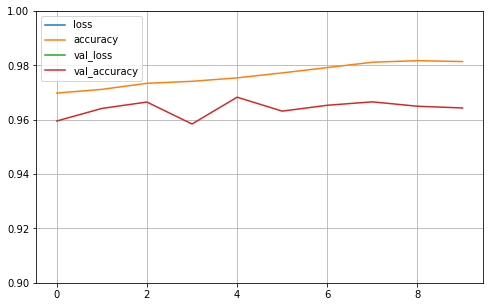

In [31]:
pd.DataFrame(history2.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0.90,1)
plt.show()

## 3.3 Section Summary

As it can be seen, when we use unmanupilated data, UNET Model with the following hyperparameters give the best accuracy of 0.9815 at 20 Epochs.

Dimesion of Filters -> 64, Dropout -> 0.2, Learning Rate -> 0.0002 and Batch Size --> 16


However when we use the data with ImageDataGenerator() function, we improve the accuracy score up to 0.9817 at 10 Epochs using the original model with the following hyperparameters.

Dimesion of Filters -> 32, Dropout -> 0.1 Learning Rate -> 0.0002 and Batch Size --> 16

## 4. VGG16

In [34]:
from tensorflow.keras.applications import vgg16
from tensorflow.keras.applications.vgg16 import VGG16

VGG16_weight = "imagenet"
vgg16 = VGG16(include_top=False, weights="imagenet", input_tensor=Input(shape=(128,128,3)))
vgg16.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
______________________________________________________________

In [35]:
set_trainable = False
for layer in vgg16.layers:
    if layer.name in ['block1_conv1']:
        set_trainable = True
    if layer.name in ['block1_pool','block2_pool','block3_pool','block4_pool','block5_pool']:
        layer.trainable = False

output_ = vgg16.output
output_

def unet_vgg(input_shape, n_filters=32, dropout = 0.1, batchnorm = True):
    vgg16 = VGG16(include_top=False, weights="imagenet", input_tensor=input_shape)
    for layer in vgg16.layers:
        layer.trainable = False
    
    s1 = vgg16.get_layer("block1_conv2").output
    s2 = vgg16.get_layer("block2_conv2").output
    s3 = vgg16.get_layer("block3_conv3").output
    s4 = vgg16.get_layer("block4_conv3").output

    b1 = vgg16.get_layer("block5_conv3").output

    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(b1)
    u6 = concatenate([u6, s4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)

    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, s3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, s2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)

    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, s1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(c9)
    vgg_model = Model(inputs=[vgg16.input], outputs=[outputs])
    return vgg_model

In [25]:
vgg_model = unet_vgg(Input(shape=(128,128,3)))
vgg_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 128, 128, 64) 1792        input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 128, 128, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 64, 64, 64)   0           block1_conv2[0][0]               
____________________________________________________________________________________________

In [26]:
vgg_model.compile(Adam(0.01), loss='binary_crossentropy', metrics=['accuracy'])

history3 = vgg_model.fit(X_train, y_train,
                        batch_size= 16,
                        epochs=20,
                        shuffle=True, 
                        verbose=1,
                        validation_data=(X_valid, y_valid), callbacks=[model_checkpoint_callback])

2022-11-10 15:16:03.315505: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 382599168 exceeds 10% of free system memory.


Epoch 1/5
122/122 [==============================] - 12s 81ms/step - loss: 0.2978 - accuracy: 0.8563 - val_loss: 0.5147 - val_accuracy: 0.9062
Epoch 2/5
122/122 [==============================] - 8s 67ms/step - loss: 0.1337 - accuracy: 0.9445 - val_loss: 0.1548 - val_accuracy: 0.9415
Epoch 3/5
122/122 [==============================] - 8s 67ms/step - loss: 0.1166 - accuracy: 0.9523 - val_loss: 0.2527 - val_accuracy: 0.9284
Epoch 4/5
122/122 [==============================] - 8s 67ms/step - loss: 0.1137 - accuracy: 0.9539 - val_loss: 0.1180 - val_accuracy: 0.9532
Epoch 5/5
122/122 [==============================] - 8s 67ms/step - loss: 0.1079 - accuracy: 0.9564 - val_loss: 0.1311 - val_accuracy: 0.9492


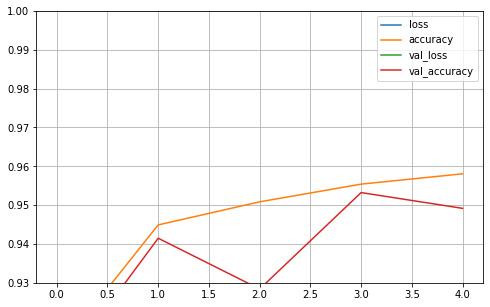

In [27]:
pd.DataFrame(history3.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0.93,1)
plt.show()

In [28]:
history4 = vgg_model.fit(train_gen, steps_per_epoch=steps, epochs=10, validation_data=val_gen, validation_steps=steps_valid)

Epoch 1/10
156/156 [==============================] - 11s 66ms/step - loss: 0.1007 - accuracy: 0.9598 - val_loss: 0.1117 - val_accuracy: 0.9575
Epoch 2/10
156/156 [==============================] - 9s 59ms/step - loss: 0.0889 - accuracy: 0.9649 - val_loss: 0.1003 - val_accuracy: 0.9604
Epoch 3/10
156/156 [==============================] - 9s 59ms/step - loss: 0.0825 - accuracy: 0.9672 - val_loss: 0.1051 - val_accuracy: 0.9591
Epoch 4/10
156/156 [==============================] - 9s 60ms/step - loss: 0.0759 - accuracy: 0.9699 - val_loss: 0.1048 - val_accuracy: 0.9582
Epoch 5/10
156/156 [==============================] - 9s 59ms/step - loss: 0.0758 - accuracy: 0.9702 - val_loss: 0.1045 - val_accuracy: 0.9608
Epoch 6/10
156/156 [==============================] - 9s 59ms/step - loss: 0.0684 - accuracy: 0.9729 - val_loss: 0.1034 - val_accuracy: 0.9606
Epoch 7/10
156/156 [==============================] - 9s 60ms/step - loss: 0.0630 - accuracy: 0.9753 - val_loss: 0.1068 - val_accuracy: 0.961

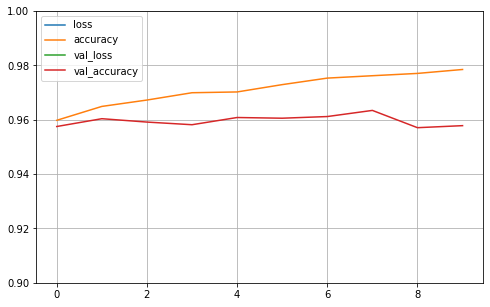

In [32]:
pd.DataFrame(history4.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0.90,1)
plt.show()

# Submission

In [30]:
y_pred = vgg_model.predict(X_test_raw)
print(y_pred.shape) # (695, 128, 128, 1)


y_pred = (y_pred > 0.5).astype(int).flatten()
print(y_pred.shape)
df_pred = pd.DataFrame({"Id": np.arange(len(y_pred)), "Predicted": y_pred})
df_pred.to_csv("submission.csv", index=False, header=True)

(695, 128, 128, 1)
(11386880,)


The model with the best kaggle score of 0.98474 is VGG16 (history4) with data generated using ImageDataGenerator().

# Discussion / Conclusion

Provide a summary of the assignment: (you are required to address **the first three** points of the list below)
- obstacles / problems you have met regarding the modelling proces
- degree of success
- given more time, what would be done differently
- further comments (if any)

Please specify which of the models was used for your final Kaggle submission.

As mentioned in a section above, we tested different hyperparameters for the **U-Net Model**. Although they did not give the all time best score on Kaggle, for unmanipulated data the model with the highest train **accuracy score of 0.9815** has the following hyperparameters. These hyperparameters gave the best accuracy among all other combinations at 10 Epochs so we decided to run this again at 20 Epochs that slightly improved the accuracy score.

**Dimesion of Filters -> 64, Dropout -> 0.2, Learning Rate -> 0.0002 and Batch Size --> 16**



However when we manipulated the data using ImageDataGenerator, the accuracy reached upto **0.9817** at 10 Epochs, which makes it the model with the highest accuracy in that section. It was achieved using the original model that has the following hyperparameters.

**Dimesion of Filters -> 32, Dropout -> 0.1 Learning Rate -> 0.0002 and Batch Size --> 16**

However the model that gave us highest **kaggle score of 0.98474** is VGG16 with data generated using ImageDataGenerator() function. This model is defined in the code as 'vgg_model'.